# Trend Removal followed by catboost

More specifically, how to detrend a time series.  Time series models tend to perform better when the dataset is 'stationary'.

A stationary series properties do not depend on the time value of a series. In statistics this means it has a constant mean, variance and no seasonality.  See <a href="https://otexts.com/fpp2/stationarity.html#fig:stationary">Forecasting: Principles and Practice</a> for examples of Stationary and non stationary datasets.
    
To get a constant mean, remove the trend.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

# Data
Use the tunnel dataset from <a href="https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data">Kaggle</a>.   It tracks the number of cars traveling through through the Baregg Tunnel in Switzerland each day from November 2003 to November 2005

In [2]:
#read data convert the Day dolumn to pandas datetime
df = pd.read_csv("../datasets/kaggle/tunnel.csv", parse_dates=["Day"])

#day is really date, change column name
df=df.rename(columns={"Day": "Date"})

df=df.set_index("Date")

#set a time index (just an integer from 0 to len dataframe)
df['Time']=np.arange(len(df))

## lets split out a test set.  <mark>You cannot use train_test_split with time series data. The earliest data is training data, the latest data is test data

In [3]:
def get_train_test(df,numb_test_rows=100):
    df_train=df.iloc[:-numb_test_rows,:].copy()
    print(df_train.shape)
    df_test=df.iloc[-numb_test_rows:,:].copy()
    print(df_test.shape)
    return df_train, df_test

df_train, df_test = get_train_test(df)

(647, 2)
(100, 2)


## What does the trend look like?
Can you see the trend below?  Is it linear?  Which direction does it go?  Is it exponential?  How would you know?

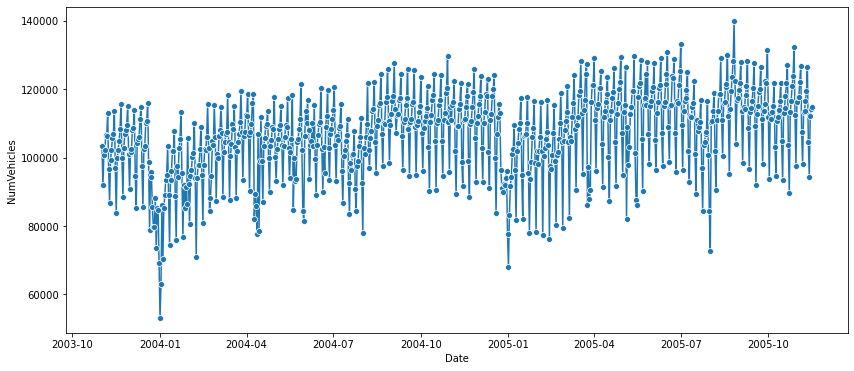

In [4]:
fig, ax1 = plt.subplots(figsize=(14,6))
_=sns.lineplot(x=df.index, y=df.NumVehicles,ax=ax1,  marker="o")

## One way is to smooth out the data so you can see the overall trend.  Then visually determine the best way to model it
Below, see I'm using a rolling average method to see what the average value is of a moving 7,28 and 256 day period<br>
<mark> why did I pick these numbers? A: Because we already showed that the data has a 7 day cycle (Mon-Sun). The moving average must be at least as long as this cycle, and preferably several times longer to smooth the approximation

In [5]:
moving_average7 = df_train.rolling(
    window=7,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=4,  # choose about half the window size
).mean()   

moving_average28 = df_train.rolling(
    window=28,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=14,  # choose about half the window size
).mean() 

moving_average256 = df_train.rolling(
    window=256,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=128,  # choose about half the window size
).mean() 
 

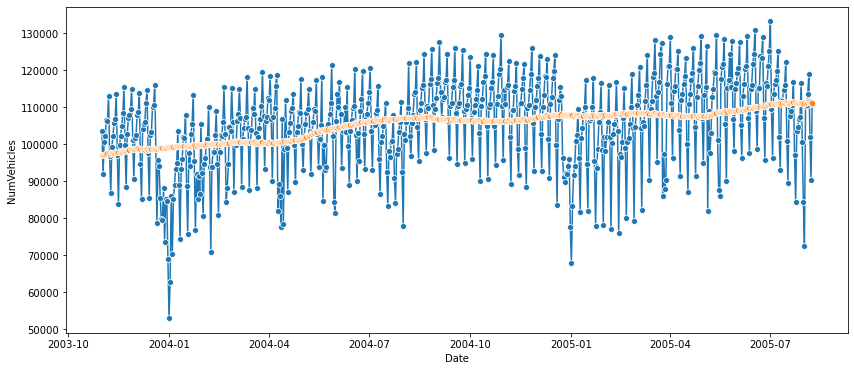

In [6]:
#lets plot them over original data
fig, ax1 = plt.subplots(figsize=(14,6))
_=sns.lineplot(x=df_train.index, y=df_train.NumVehicles,ax=ax1,  marker="o")
_=sns.lineplot(x=moving_average256.index, y=moving_average256.NumVehicles,ax=ax1,  marker="o")

# The moving average is showing that the overall trend is linear, so approximate it with linear regression

If it is not linear I would consider polynomial regression.  Something to capture the overall shape of the moving average line

In [7]:
from utils1 import train_model
mod1=train_model(df_train.Time.values.reshape(-1,1), df_train.NumVehicles)
preds=mod1.predict(df_train.Time.values.reshape(-1,1))

## OK The model approximates Trend.  If you subtract this trend you are left with the residuals (and a detrended dataset).  You can use the model to add it back later when forcasting using unseen data.

In [8]:
df_train1=df_train.copy()
df_train1.NumVehicles=df_train1.NumVehicles-preds

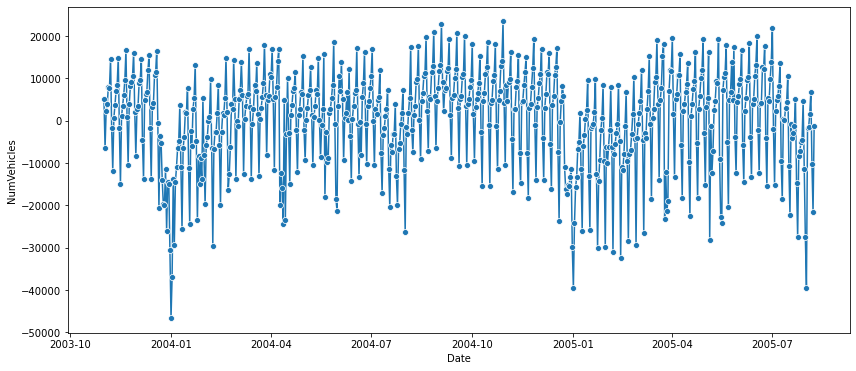

In [9]:
fig, ax1 = plt.subplots(figsize=(14,6))
_=sns.lineplot(x=df_train1.index, y=df_train1.NumVehicles,ax=ax1,  marker="o")

## But there is still seasonality, specifically a 7 day repeating pattern

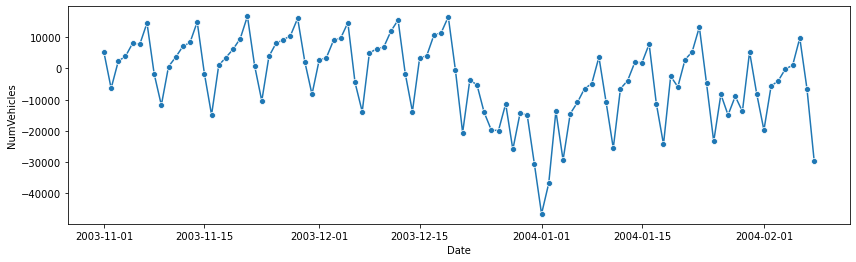

In [10]:
#get the first 100 rows
df_train1=df_train1.iloc[:100,:]

#and lets see them
fig, ax1 = plt.subplots(figsize=(14,4))
_=sns.lineplot(x=df_train1.index, y='NumVehicles', data=df_train1,ax=ax1,  marker="o")

## Before we try removing this seasonality, lets see if a gradient boosted tree (catboost) can do well on the detrended data
<mark> But it needs more information to go on than a single column,  all we can use are lags, whats a good number?<br>
since we have a repeating cycle of 7 days, lets add 7 lags to see if it helps the tree
    
1. detrend whole dataset: no informaton is leaked into the test set since we are using linera regression coefficients that were calculated on train set only!<br>
2. add lags to entire data set: still no lags added
3. drop rows with NaNs (we may be able to do better in practice)
4. resplit the newly lagged, detrended dataset
5. train regressor
6. use repressor to predict on test data
6. get rsquared
    

In [11]:
df1=df.copy()

#we detrended earlier on train set, detrend on whole dataset now 
df1.NumVehicles=df1.NumVehicles-mod1.predict(df1.Time.values.reshape(-1,1))

#and add lags
for i in range(1,8):
    df1['Lag_'+str(i)]=df['NumVehicles'].shift(i)
df1.head(10)
df1.dropna(inplace=True)  #alas goodbye to 7 rows

#finaly split it
df_train, df_test = get_train_test(df1)

(640, 9)
(100, 9)


In [12]:
#seperate target
df_train_y=df_train['NumVehicles']
df_train.drop(columns=['NumVehicles'],inplace=True)

df_test_y=df_test['NumVehicles']
df_test.drop(columns=['NumVehicles'],inplace=True)

In [13]:
%%time
from catboost import CatBoostRegressor
clf = CatBoostRegressor(silent=True, random_state=42)
_=clf.fit(df_train, df_train_y)

CPU times: user 6.09 s, sys: 584 ms, total: 6.68 s
Wall time: 621 ms


In [14]:
from utils1 import rsquared
preds=clf.predict(df_test)
score=rsquared(preds,df_test_y)
score

0.6705614623058506

## Lets see what this looks like

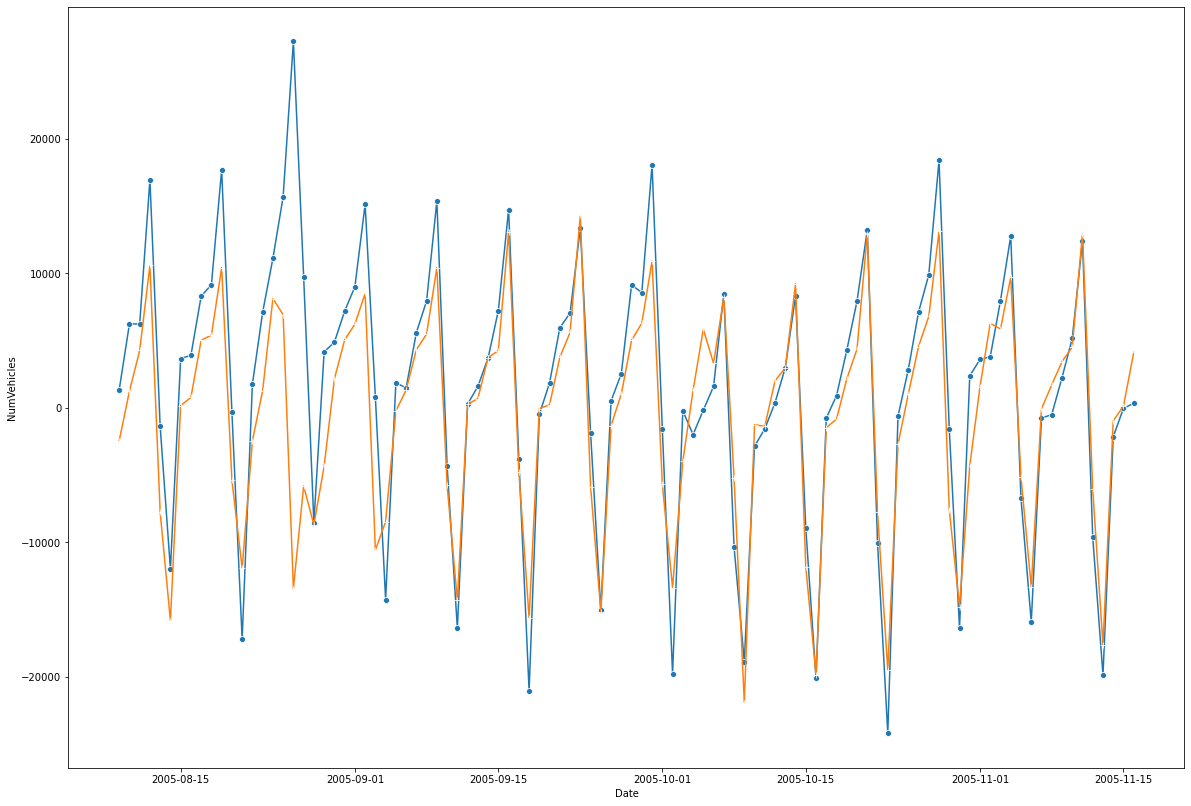

In [15]:
fig, ax1 = plt.subplots(figsize=(20,14))
_=sns.lineplot(x=df_test_y.index, y=df_test_y,ax=ax1,  marker="o")
_=sns.lineplot(x=df_test_y.index, y=preds,ax=ax1,  marker="+")

# <mark> Permutation Importance 

In [16]:
from sklearn.inspection import permutation_importance

In [20]:
%%time
feature_names=df_test.columns
result = permutation_importance(
    clf, df_test, df_test_y, n_repeats=10, random_state=42, n_jobs=2, scoring=None)
forest_importances = pd.Series(result.importances_mean, index=feature_names)

CPU times: user 16.9 ms, sys: 4.4 ms, total: 21.3 ms
Wall time: 79.2 ms


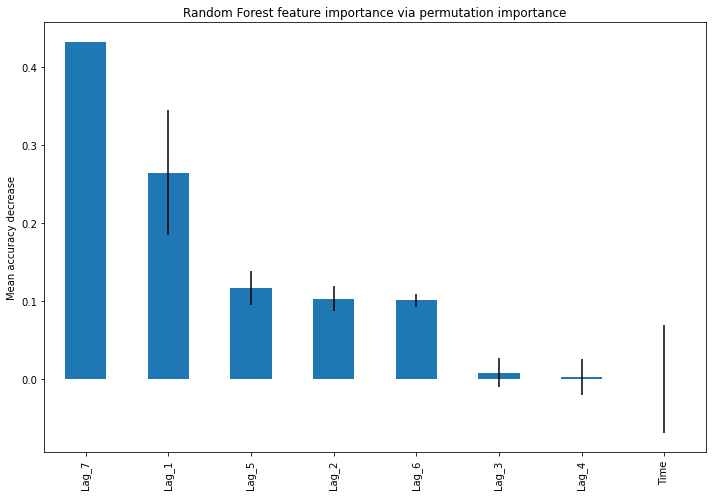

In [21]:
#plot em
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,7))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Random Forest feature importance via permutation importance")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()